Строим первую нейронную сеть

Решение задачи регрессии - предсказание некоторого вещ числа

In [0]:
import torch
import matplotlib.pyplot as plt

In [0]:
#для рисования графиков
import matplotlib
matplotlib.rcParams['figure.figsize'] = (13.0, 5.0)

Train dataset

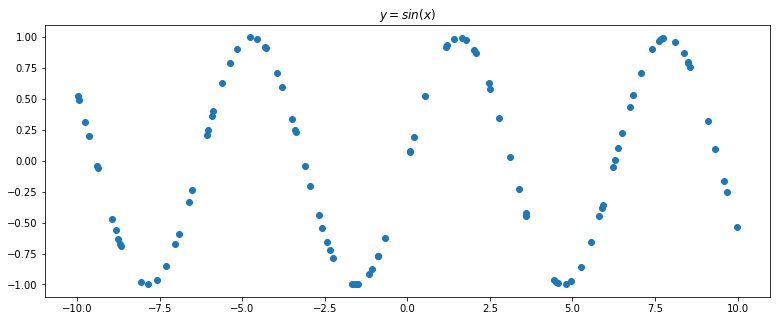

In [0]:
#равномерное распределение от 0 до 1 - 100 точек
x_train = torch.rand(100)
#ориентируем график по центру
x_train = x_train * 20.0 - 10.0
#синусы от данных точек
y_train = torch.sin(x_train)

plt.plot(x_train.numpy(), y_train.numpy(), 'o')
plt.title('$y = sin(x)$');

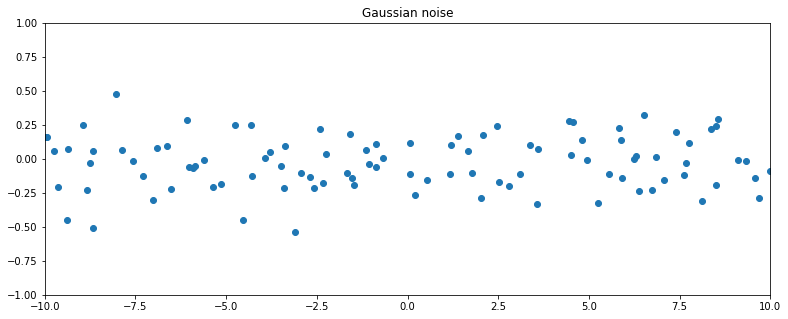

In [0]:
#шум из нормального распределения
noise = torch.randn(y_train.shape) / 5.

plt.plot(x_train.numpy(), noise.numpy(), 'o')
plt.axis([-10, 10, -1, 1])
plt.title('Gaussian noise');

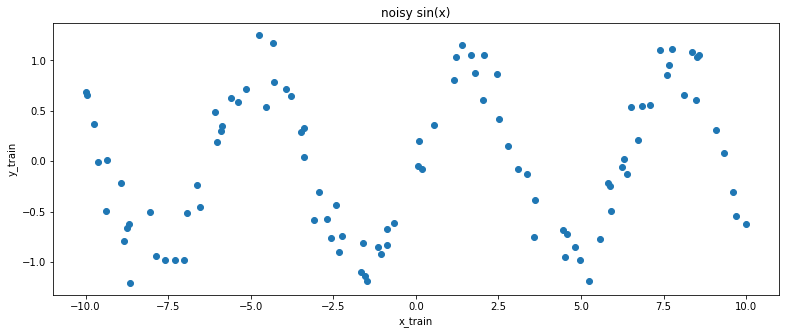

In [0]:
#прибавим каждую точку шума к каждой точке синуса
#получились зашумленные данные
y_train = y_train + noise
plt.plot(x_train.numpy(), y_train.numpy(), 'o')
plt.title('noisy sin(x)')
plt.xlabel('x_train')
plt.ylabel('y_train');

In [0]:
#сейчас у нас параметр - число x - одна строка
#но может быть несколько параметров - вектор параметров
#превращаем данные в столбцы, где каждая строка -это параметр
x_train.unsqueeze_(1)
y_train.unsqueeze_(1);

In [0]:
#был одномерный тензор, стал двумерный тензор
tmp = torch.Tensor([1,2,3])
print(tmp)
print(tmp.unsqueeze(1))

tensor([1., 2., 3.])
tensor([[1.],
        [2.],
        [3.]])


Validation dataset

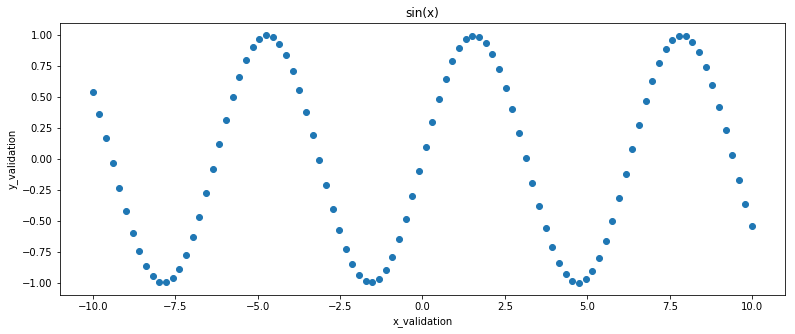

In [0]:
#за валидационный датасет возьмем просто ф-цию синуса, без шума
#обычный синус, точки распределены равномерно от -10 до 10
x_validation = torch.linspace(-10, 10, 100)
y_validation = torch.sin(x_validation.data)
plt.plot(x_validation.numpy(), y_validation.numpy(), 'o')
plt.title('sin(x)')
plt.xlabel('x_validation')
plt.ylabel('y_validation');

In [0]:
#задаем правильную размерность
x_validation.unsqueeze_(1)
y_validation.unsqueeze_(1);

Model construction

In [0]:
#создаем нейронную сеть
#создаем класс, наследование от torch.nn.Module
class SineNet(torch.nn.Module):
  #ф-ция инициализации, принимает любые необходимые параметры
  #параметр n_hidden_neurons - количество скрытых нейронов на каждом слое (здесь везде одинаковое количство)
    def __init__(self, n_hidden_neurons):
      #инициализируем родительский обьект
        super(SineNet, self).__init__()
        #слои:
        #fc1 - fully connected - полносвязный первый слой, обозначается Linear
        #передаем количество входных и выходный нейронов
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons)
        #функция активации
        self.act1 = torch.nn.Sigmoid()
        #еще один слой, один выход - ответ на вопрос регрессии
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1)
#ф-ция, описывающая последовательное применение слоев
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

#создаем сеть, задаем количество скрытых нейронов
sine_net = SineNet(50)

Prediction

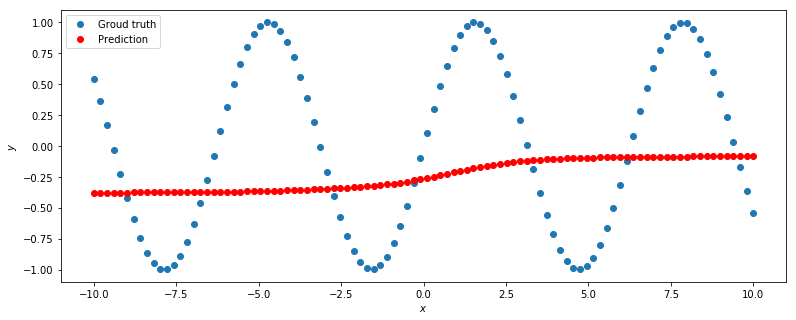

In [0]:
def predict(net, x, y):
 #вызов метода forward
    y_pred = net.forward(x)
#визуализация: красное - предсказание
    plt.plot(x.numpy(), y.numpy(), 'o', label='Groud truth')
    plt.plot(x.numpy(), y_pred.data.numpy(), 'o', c='r', label='Prediction');
    plt.legend(loc='upper left')
    plt.xlabel('$x$')
    plt.ylabel('$y$')

predict(sine_net, x_validation, y_validation)
#без обучения получилась какая-то случайная кривая

Optimizer

In [0]:
#SGD работает не очень хорошо, используем Adam
#параметры: веса нейронной сети, находятся в sine_net.parameters()
#их нужно модифицировать в ходе град спуска, и lr - learning rate 
optimizer = torch.optim.Adam(sine_net.parameters(), lr=0.01)

Loss function

In [0]:
#MSE (mean squared error)
#pred - предсказание нейронной сети, target - реальное зн-е, кот соответствует данной точке
def loss(pred, target):
  #возводим в квадрат
    squares = (pred - target) ** 2
    #считаем среднее значение
    return squares.mean()

Training procedure

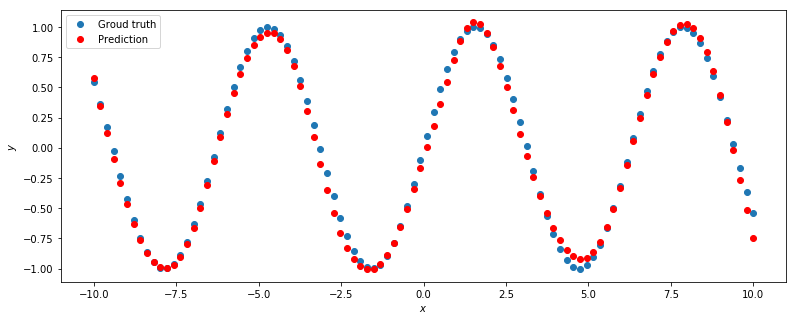

In [0]:
#эпоха: посмотрели один раз датасет
#2000 эпох
for epoch_index in range(2000):
  #зануляем градиенты
    optimizer.zero_grad()
  #считаем предсказание с помощью forward
    y_pred = sine_net.forward(x_train)
  #считаем ф-цию потерь
    loss_val = loss(y_pred, y_train)
  #делаем backward
    loss_val.backward()
  #оптимайзер делает шаг
    optimizer.step()

#посмотрим результат - очень хорошо!
predict(sine_net, x_validation, y_validation)

-----------------
Wine prediction

Решение задачи классификации


In [0]:
import torch
import random
import numpy as np


#зафиксируем случайность выбора случайных чисел
#seed - "номер последовательности" случайных чисел, которые выдает генератор
#много разных случайных генераторов, зафиксируем все:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
#если хотим воспроизводимость, то тут должно быть true
torch.backends.cudnn.deterministic = True

In [0]:
#используем готовый датасет про вина
#178 бутылок вин, для каждой 13 параметров - вещ числа, три класса для классификации
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [0]:
#разбивает датасет на train и test
from sklearn.model_selection import train_test_split

#1-й параметр - датасет, используем только первые две колонки
#2-й параметр - таргеты - классы, кот нужно предсказать - колонка с номерами классов
#3: отрезаем 30 процентов в тест
#4: перемешиваем
X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2], 
    wine.target, 
    test_size=0.3, 
    shuffle=True)

#оборачиваем фолды в торч тензоры
#дробные числа - float, целые числа - long
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [0]:
#реализуем класс - нейросеть для классификации
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        #всего три слоя, два из них скрытые
        #2 входа - 2 входных параметра
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        #3 выходных нейрона, каждый отвечает за свой класс
        #на выходе некоторые числа, мы передадим их в софтмакс и получим вероятности
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
      
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        #не используем софтмакс:
        #бинарная кросс-энтропия - это логарифмы, софтмакс - это экспоненты
        #они взаимно уничтожаются
        #чтобы считать лоссы софтмакс не нужен, чтобы посчитать вероятность мы потом будем использоовать софтмакс
        #софтмакс- ф-я долгого вычисления, стараемся ее избегать
        return x

    #ф-я, которая считает софтмакс 
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
#создаем нейросеть, задаем кол-во скрытых нейронов
wine_net = WineNet(5)

In [0]:
#инициализируем ф-ю потерь
#используются выходы из нейронной сети, не пропущенные через софтмакс
loss = torch.nn.CrossEntropyLoss()

#оптимайзер: передаем веса и learning rate
optimizer = torch.optim.Adam(wine_net.parameters(), 
                             lr=1.0e-3)

In [0]:
#весь датасет может не поместиться в память, поэтому обрабатываем по кусочкам
#кусочек называется батч

#ф-ция permutation выдает индексы от 0 до 5 в случайном порядке
np.random.permutation(5)

array([2, 0, 1, 4, 3])

In [0]:
#размер кусочка
batch_size = 10

for epoch in range(5000):
  #переменная order определяется каждую эпоху - это новый порядок индексов
    order = np.random.permutation(len(X_train))
    #start_index принмает значения 0, 10, 20... до конца датасета
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        #некоторые индексы, котрые соответствуют определенному батчу
        #так мы каждую эпоху гарантированно проходим все значения в датасете один раз
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        #предсказание - выходы на послед трех нейронах
        preds = wine_net.forward(x_batch) 
        #считаем лосс на выходах и реальных знаениях
        loss_value = loss(preds, y_batch)
        #считаем производную
        loss_value.backward()
        #оптимайзер делает шаг
        optimizer.step()
        
    #каждые 100 эпох будем вычислять метрики на датасете, чтобы контролировать обучение
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        #смотрим, какой выход максимальный
        #он же и даст в последствии максимальную веоятность
        #получаем номер нейрона и сравниваем с номером класса, кот должен быть
        test_preds = test_preds.argmax(dim=1)
        #надо посчитать среднее значение, для этого надо перевести в float
        print((test_preds == y_test).float().mean())

tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)


KeyboardInterrupt: ignored

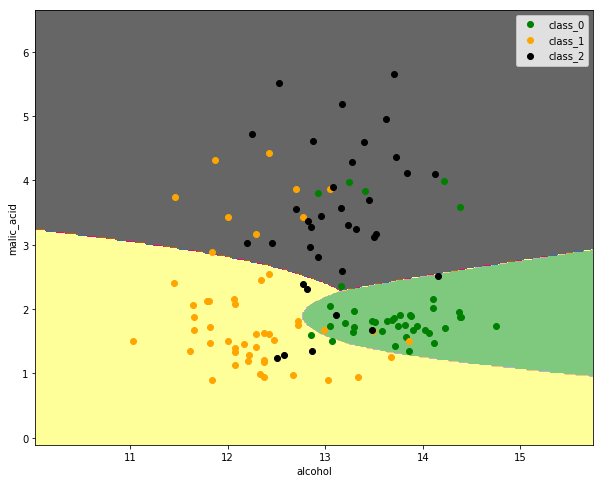

In [0]:
#визуализация
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

--------------------
Самостоятельная работа

Wine_task

In [0]:
import torch
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine

In [0]:
wine = load_wine()
features = 13 # use 13 features

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :features], 
    wine.target, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [0]:
class WineNet(torch.nn.Module):
    def __init__(self,n_input, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(n_input, n_hidden_neurons)
         # your code here
        self.activ1 = torch.nn.Sigmoid() 
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)

        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
n_input = 13 # choose number of input neurons
n_hidden = 50 # choose number of hidden neurons
wine_net = WineNet(n_input, n_hidden)

In [0]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3)

In [0]:
batch_size = 10 # choose different batch sizes

for epoch in range(2000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 10 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)

In [0]:
print(wine_net.fc1.in_features, np.asarray((test_preds == y_test).float().mean()) > 0.8)
# need to get 13 True

13 True
